### Semantic features as word embeddings

In [1]:
import numpy as np
import os
import torch
import json
from tqdm import tqdm
import scipy
import pandas as pd

### fMRI data

In [2]:
def get_mitchell_original_data(subject = 1, random_voxels = None):
    mdata = scipy.io.loadmat(os.path.join("data", "mitchell", f"mitchell_subject_{subject}.mat"))
    subject_data = {}

    # 6 x 60 trials
    for i in range(mdata["data"][:].shape[0]):
        cond, cond_number, word, word_number, epoch = [x[0] for x in mdata["info"][0][i]]

        # Set trial data
        if epoch[0] not in subject_data: subject_data[epoch[0]] = {}

        if random_voxels:
            random_voxels_idx = np.random.choice(mdata["data"][i][0][0].shape[0], random_voxels)
            subject_data[epoch[0]][word] = mdata["data"][i][0][0][random_voxels_idx]
        else: subject_data[epoch[0]][word] = mdata["data"][i][0][0]

    return subject_data

**Taking the most stable voxels**

Supplement online material Mitchell et al., page 6.

In [3]:
K = 500
fmriData = get_mitchell_original_data(subject=1)
voxels = fmriData[1]["bell"].shape[0]

# Get scores of the voxels
scores = []
for vx in range(voxels):
    repetitions = []
    for epoch in fmriData.keys():
        repetitions.append(np.array([fmriData[epoch][word][vx] for word in fmriData[epoch].keys()]))
    repetitions = np.array(repetitions)

    voxel_correlation_score = []
    for row in repetitions:
        for column in repetitions:
            voxel_correlation_score.append(np.correlate(row, column))
    
    scores.append(np.mean(voxel_correlation_score))

ind = np.argpartition(scores, -K)[-K:]

filteredfMRIData = {}
for word, activations in fmriData[6].items():
    filteredfMRIData[word] = activations[ind]

### GloVe embeddings

In [4]:
def get_word_activations(path, skip_lines=0):
    """
        Returns dataset of fMRI word activations
        path            Path to .txt fMRI data vectors (continuous) from Cognival
        context_len     Words before the occurring one
        data            Returned dictionary with key ['word'] -> {'context', 'activations'}
    """
    data = {}
    with open(path, "r") as datafile:
        lines = datafile.readlines()[skip_lines:] # skip header
        for line in tqdm(lines):
            word = line.split(" ")[0]
            activations = np.array([float(x) for x in line.split(" ")[1:]])
            data[word] = {"activations": activations}
    return data

In [5]:
filename = os.path.join("data", "glove.6B", f"glove.6B.100d.txt")
glove_embeddings = get_word_activations(filename, skip_lines = 0)

100%|██████████| 400000/400000 [00:11<00:00, 35893.14it/s]


### Predicting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# Building train set
X = []
Y = []

for word in tqdm(glove_embeddings.keys()):
    if word in filteredfMRIData.keys():
        X.append(glove_embeddings[word]["activations"])
        Y.append(filteredfMRIData[word])

100%|██████████| 400000/400000 [00:00<00:00, 3226220.18it/s]


In [8]:
# Fetch fMRI activations from the dataset
X = np.array(X)
Y = np.array(Y)

X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.02, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(58, 100) (2, 100)
(58, 500) (2, 500)


In [9]:
# make_pipeline(StandardScaler(with_mean=False), LinearRegression())
predictors = [make_pipeline(StandardScaler(with_mean=False), LinearRegression()) for i in range(K)]
scores = []

# One predictor per voxel
i = 0
for model in tqdm(predictors):
    model.fit(X_train, y_train[:, i])
    scores.append(model.score(X_test, y_test[:, i]))
    i += 1

scores = np.array(scores)

100%|██████████| 500/500 [00:01<00:00, 378.36it/s]


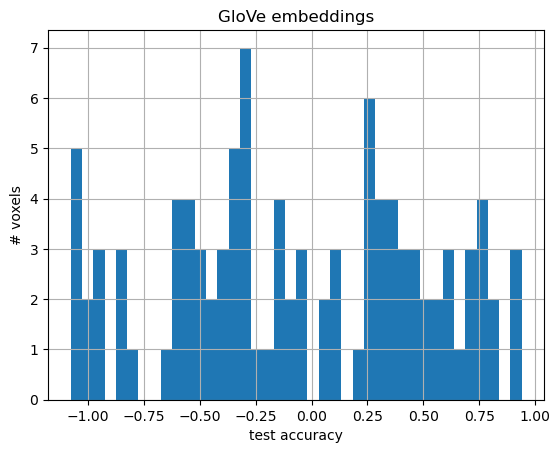

In [16]:
K = 100
ind = np.argpartition(scores, -K)[-K:]

plt.title("GloVe embeddings")
plt.xlabel("test accuracy")
plt.ylabel("# voxels")
plt.hist(scores[ind], bins=40)
plt.grid()

(0.0, 1.0)

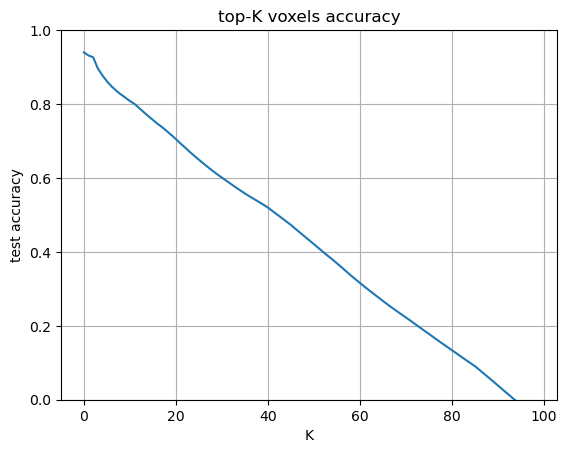

In [11]:
# Picking the best 100 predictors per voxel
subset_scores = [np.mean(scores[np.argpartition(scores, -subset_size)[-subset_size:]]) for subset_size in range(1, 100)]

plt.title("top-K voxels accuracy")
plt.plot(subset_scores)
plt.ylabel("test accuracy")
plt.xlabel("K")
plt.grid()
plt.ylim([0, 1])

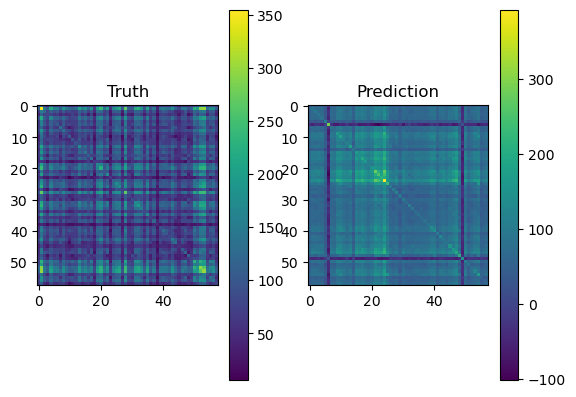

In [12]:
from scipy.stats import pearsonr

K = 50
ind = np.argpartition(scores, -K)[-K:]

# According to the last subject
def best_K_predict(X, indices, predictors):
    predictors = [predictors[idx] for idx in indices]
    y_hat = np.array([predictor.predict(X) for predictor in predictors]) # voxels, sample
    return y_hat.reshape(y_hat.shape[1], y_hat.shape[0]) # sample, voxels

y_hat = best_K_predict(X_train, ind, predictors)
y = y_train[:, ind]

RDM_hat = np.matmul(y_hat, np.matrix.transpose(y_hat))
# RDM_hat = (RDM_hat - RDM_hat.min()) / (RDM_hat.max() - RDM_hat.min())

RDM = np.matmul(y, np.matrix.transpose(y))
# RDM = (RDM - RDM.min()) / (RDM.max() - RDM.min())

test_pearson = pearsonr(
    RDM_hat.flatten(),
    RDM.flatten()
)

plt.subplot(121)
plt.title("Truth")
plt.imshow(RDM)
plt.colorbar()

plt.subplot(122)
plt.title("Prediction")
plt.imshow(RDM_hat)
plt.colorbar()